In [1]:
import hdf5plugin
import h5py    
import numpy as np  
import pandas as pd

In [2]:
def print_all_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            print(prefix + key)  # Print the dataset name
        elif isinstance(item, h5py.Group):
            print_all_datasets(item, prefix + key + '/')  # Recursively explore groups
            
def list_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, pd.DataFrame):
            print(prefix + key)  # Print the dataset path
        elif isinstance(item, pd.io.pytables.HDFStore):
            list_datasets(item, prefix + key + '/')  # Recursively explore groups


default_colors = {0: 'green', 1: 'blue', 2: 'orange', 3: 'red'}
import matplotlib.pyplot as plt
import matplotlib

In [3]:
region_name = 'IGFBP2_regions'
celltype = 'enterocytes'
fold = 'fold_0'
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

regions_df = pd.read_csv('region_scores/'+celltype+'/'+region_name+"/"+fold+".interpreted_regions.bed", sep='\t', names=NARROWPEAK_SCHEMA)

seq_length = 2114
regions_df['int_start'] = regions_df['start']+regions_df['summit']-seq_length/2
regions_df['int_end'] = regions_df['start']+regions_df['summit']+seq_length/2



In [4]:
regions_df

,chr,start,end,1,2,3,4,5,6,summit,int_start,int_end
0,chr2,216636508,216637488,human_peaks_peak_48293,380,.,5.29416,40.7695,38.0041,799,216636250.0,216638364.0
1,chr2,216863820,216864761,human_peaks_peak_48308,340,.,7.94451,36.7715,34.0687,362,216863125.0,216865239.0
2,chr2,216863820,216864761,human_peaks_peak_48308,340,.,7.94451,36.7715,34.0687,362,216863125.0,216865239.0


In [5]:
def get_model_score(file_path,sequence_number):
    import h5py
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        dataset = f['shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get contribution_scores
        df = pd.DataFrame(dataset[sequence_number][:])
    
        # Access the dataset
        dataset = f['raw']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df2 = pd.DataFrame(dataset[sequence_number][:])


        # Access the dataset
        dataset = f['projected_shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df4 = pd.DataFrame(dataset[sequence_number][:])

    df3 = df*df2

    return(df2,df3)
        

In [6]:
model_head = 'counts' #either profile or counts

In [7]:
sequence_number = 1
sequence_chr,sequence_start,sequence_end = regions_df.loc[sequence_number,'chr'],int(regions_df.loc[sequence_number,'int_start']),int(regions_df.loc[sequence_number,'int_end'])
seq_list = []
folds = ['fold_0','fold_1','fold_2','fold_3','fold_4']
i = 0
for fold in folds:

    file_path = 'region_scores/'+celltype+'/'+region_name+"/"+fold+"."+model_head+"_scores.h5"
    dataset_key = '/projected_shap/seq'  # Adjust the dataset key as needed

    seq,model_score_fold = get_model_score(file_path,sequence_number)
    seq_list.append(seq)
    if i == 0:
        model_score_sum = model_score_fold
        i+=1
    else:
        model_score_sum = model_score_sum + model_score_fold

model_score_avg = model_score_sum/len(folds)

In [8]:
seq_df = model_score_avg.T
seq_df.columns = ['A','C','G','T']

In [9]:

import numpy as np
# Generate a 100bp grid
grid = np.linspace(0, 2114, num=22)
# Round each grid value to the nearest multiple of 100
rounded_grid = np.round(grid / 100) * 100
# Add starting position
grid2 = [x+sequence_start for x in rounded_grid]
# Round to nearest multiple of 100
rounded_grid2 = np.round(np.array(grid2) / 100) * 100
rounded_grid2 = [int(x) for x in rounded_grid2]
#Reset locations
tick_locations = [x-sequence_start for x in rounded_grid2]
#Add chr to first tick
rounded_grid2 = [str(x) for x in rounded_grid2]
rounded_grid2[0] = sequence_chr+": " + str(rounded_grid2[0])

In [10]:
region_name

'IGFBP2_regions'

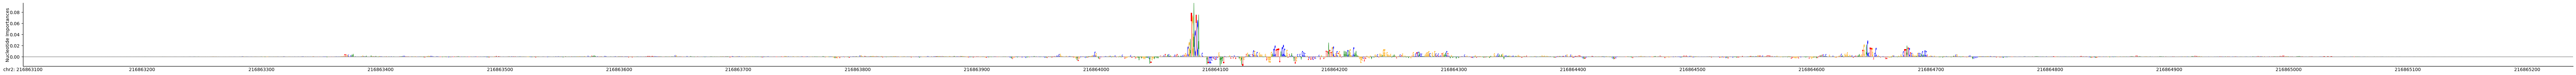

In [11]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df,figsize=(100, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_"+model_head+".png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_"+model_head+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [12]:
max_contrib = np.abs(seq_df.T).max()
max_contrib_Z = (max_contrib-max_contrib.mean())/max_contrib.std()

In [13]:
max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>2]
min_pos = np.array(max_contrib_Z_thresh.index).min()
max_pos = np.array(max_contrib_Z_thresh.index).max()

min_pos = np.max([min_pos - 20,1])
max_pos = np.min([max_pos+20,2000])
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

678


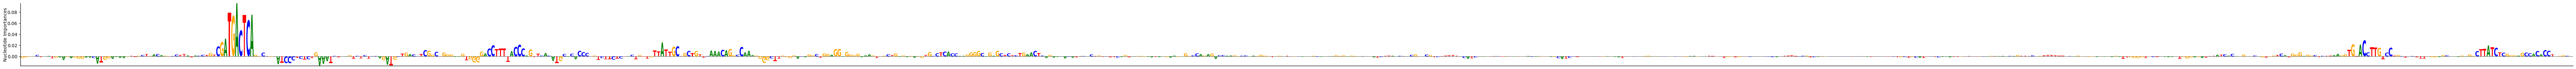

In [14]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df_trimmed,figsize=(100/2000*len(seq_df_trimmed.index)*3, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_"+model_head+"_trimmed_2.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_"+model_head+"_trimmed_2.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [14]:
#CAAAGTCC: HNF4
#TGAGTCA: JUN + FOS2L
#GGGTGTGGC: KLF3

In [15]:
max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>5]
min_pos = np.array(max_contrib_Z_thresh.index).min()
max_pos = np.array(max_contrib_Z_thresh.index).max()

min_pos = np.max([min_pos - 20,1])
max_pos = np.min([max_pos+20,2000])
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

609


In [16]:
min_pos,max_pos

(934, 1542)

In [17]:
def plot_region_ISM(seq_df,ISM_df,highlight_SNP=None):

    

    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import logomaker
    import numpy as np

    base_colors = {}
    base_colors['A'] = 'g'
    base_colors['C'] = 'b'
    base_colors['G'] = 'gold'
    base_colors['T'] = 'r'

    # Assuming len_seq and celltypes are defined
    len_seq = len(seq_df.index)
    min_pos = np.min(seq_df_trimmed.index)
    max_pos = np.max(seq_df_trimmed.index)
    
    # Create a figure
    fig = plt.figure(figsize=(300/2000*len_seq,5))

    # Create a GridSpec with 1 column and rows equal to the number of cell types
    gs = gridspec.GridSpec(2, 1, figure=fig)

    # Create axes in each grid cell with shared y-axis
    axes = [fig.add_subplot(gs[i, 0]) for i in [0,1]]

    ax = axes[0]
    ax.set_title(celltype)    
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
#    crp_logo.ax.yaxis.set_ylabel('test')

    ax.set_ylabel("Nucleotide Importances",fontsize=10)

    ax1 = axes[1]
    ax1.axhline(y=0,xmin=min_pos,xmax=max_pos,linewidth=2)
    ax1.set_ylabel("$\Delta$ Log[counts]",fontsize=10)
    
    for base in ['A','G','T','C']:
        df_base = ISM_df_trimmed.loc[ISM_df_trimmed['alt']==base].copy()
    
        x,y = df_base['pos'],df_base['log_counts_diff_avg']
        ax1.scatter(x,y,c=base_colors[base])

    if highlight_SNP:
        snp_pos = highlight_SNP.keys()

        for pos in snp_pos:
            base = highlight_SNP[pos]
            df_base = ISM_df_trimmed.loc[ISM_df_trimmed['alt']==base].copy()
            df_base = df_base.loc[df_base['pos']==pos]
            x,y = df_base['pos'],df_base['log_counts_diff_avg']
            ax1.scatter(x,y,c=base_colors[base],edgecolors='k',linewidths=2)      

    
    ax1.set_xlim([min_pos,max_pos])
    ax1.axhline(y=0,xmin=min_pos,xmax=max_pos,linewidth=2)

    plt.show()
    plt.close()
    

In [80]:
ISM_df = pd.read_csv("IGFBP2_distal_ISM_study_effects_wcounts.tsv",sep="\t",index_col=0)
ISM_df_trimmed = ISM_df.loc[ISM_df['pos']<=max_pos]
ISM_df_trimmed = ISM_df_trimmed.loc[ISM_df_trimmed['pos']>=min_pos]


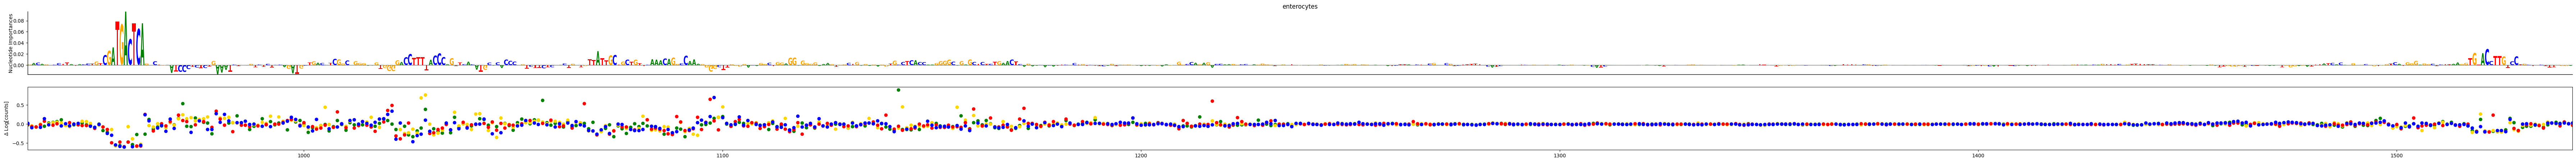

In [19]:
plot_region_ISM(seq_df_trimmed, ISM_df_trimmed)

In [ ]:
#	ID	chr	pos(hg38)	Human	Chimp
#1	IGFBPi_1	chr2	216638002	G	A
#2	IGFBPi_2	chr2	216636815	G	A
#3	IGFBPi_3	chr2	216636845	T	C
#4	IGFBPi_4	chr2	216636873	C	T
#5	IGFBPi_5	chr2	216636888	G	A

In [ ]:
chr2	216863971	G	A	within HAR, human allele is the ancestral allele, chimp allele is the derived allele, mammal specific site
chr2	216864000	C	T   within HAR, human allele is derived allele, different from most of other mammals 
chr2	216864074	C	A   within HAR, human allele is derived allele, different from other species 
chr2	216864126	C	T   within HAR, human allele is derived allele, different from other species
chr2	216864160	A	T   within HAR, human allele is derived allele, different from other species 
chr2	216864175	C	T   within HAR, human allele is the ancestral allele, chimp allele is the derived allele 

chr2	216864196	A	G   within HAR, human allele is derived allele, different from most of other mammals 
chr2	216864197	T	C   within HAR, human allele is derived allele, different from most of other mammals 

chr2	216861231	C	T   human specific SNC as compared to other great apes, human allele is derived allele, different from most of other mammals  
chr2	216868162	A	C   human specific SNC as compared to other great apes, human allele is derived allele, different from most of other mammals 
chr2	216870272	G	A   human specific SNC as compared to other great apes, human allele is shared with oppossum and platypus, chimp allele is shared with gorilla and painted turtle, and this site is absent in other species 


In [69]:
216864197-regions_df['int_start']-1

0    227946.0
1      1071.0
2      1071.0
Name: int_start, dtype: float64

In [70]:
seq_df.loc[1071]

A    0.000000
C    0.000000
G    0.000000
T    0.012222
Name: 1071, dtype: float16

In [71]:
highlight_SNP = {}
highlight_SNP[845] = 'A'
highlight_SNP[874] = 'T'
highlight_SNP[948] = 'A'

highlight_SNP[1000] = 'T'
highlight_SNP[1034] = 'T'
highlight_SNP[1049] = 'T'

highlight_SNP[1070] = 'G'
highlight_SNP[1071] = 'C'

In [84]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib

def plot_region_ISM(seq_df, ISM_df, highlight_SNP=None, save_path=None):
    base_colors = {
        'A': 'g',
        'C': 'b',
        'G': 'gold',
        'T': 'r'
    }

    len_seq = len(seq_df)
    min_pos = np.min(seq_df.index)
    max_pos = np.max(seq_df.index)

    # Create a figure
    fig = plt.figure(figsize=(300 / 2000 * len_seq, 5))

    # Create a GridSpec with 2 rows and 1 column
    gs = gridspec.GridSpec(2, 1, figure=fig)

    # Create axes in each grid cell with shared x-axis
    axes = [fig.add_subplot(gs[i, 0]) for i in range(2)]

    # Plot the sequence logo
    ax = axes[0]
    crp_logo = logomaker.Logo(seq_df, shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)

    ax.set_ylabel("Nucleotide Importances", fontsize=10)

    # Plot the ISM data
    ax1 = axes[1]
    ax1.axhline(y=0, color='black', linewidth=1, linestyle='--')

    ax1.set_ylabel("$\Delta$ Log[counts]", fontsize=10)
    
    for base in ['A', 'G', 'T', 'C']:
        df_base = ISM_df[ISM_df['alt'] == base].copy()
        x, y = df_base['pos'], df_base['log_counts_diff_avg']
        ax1.scatter(x, y, c=base_colors[base], label=base)

    if highlight_SNP:
        for pos, base in highlight_SNP.items():
            df_base = ISM_df[(ISM_df['alt'] == base) & (ISM_df['pos'] == pos)]
            x, y = df_base['pos'], df_base['log_counts_diff_avg']
            ax1.scatter(x, y, c=base_colors[base], edgecolors='k', linewidths=3)

    ax1.set_xlim([min_pos, max_pos])

    # Adding legend to the second subplot
    ax1.legend()

    if save_path:
        plt.savefig(save_path,dpi=350,bbox_inches='tight',pad_inches=0)
    plt.show()
    plt.close()


In [85]:
highlight_SNP

{845: 'A',
 874: 'T',
 948: 'A',
 1000: 'T',
 1034: 'T',
 1049: 'T',
 1070: 'G',
 1071: 'C'}

In [88]:
plot_min_pos = 830
plot_max_pos = 1100
seq_df_plot = seq_df[plot_min_pos:plot_max_pos]
ISM_df_plot = ISM_df.loc[ISM_df['pos']<=plot_max_pos]
ISM_df_plot = ISM_df_plot.loc[ISM_df_plot['pos']>=plot_min_pos]


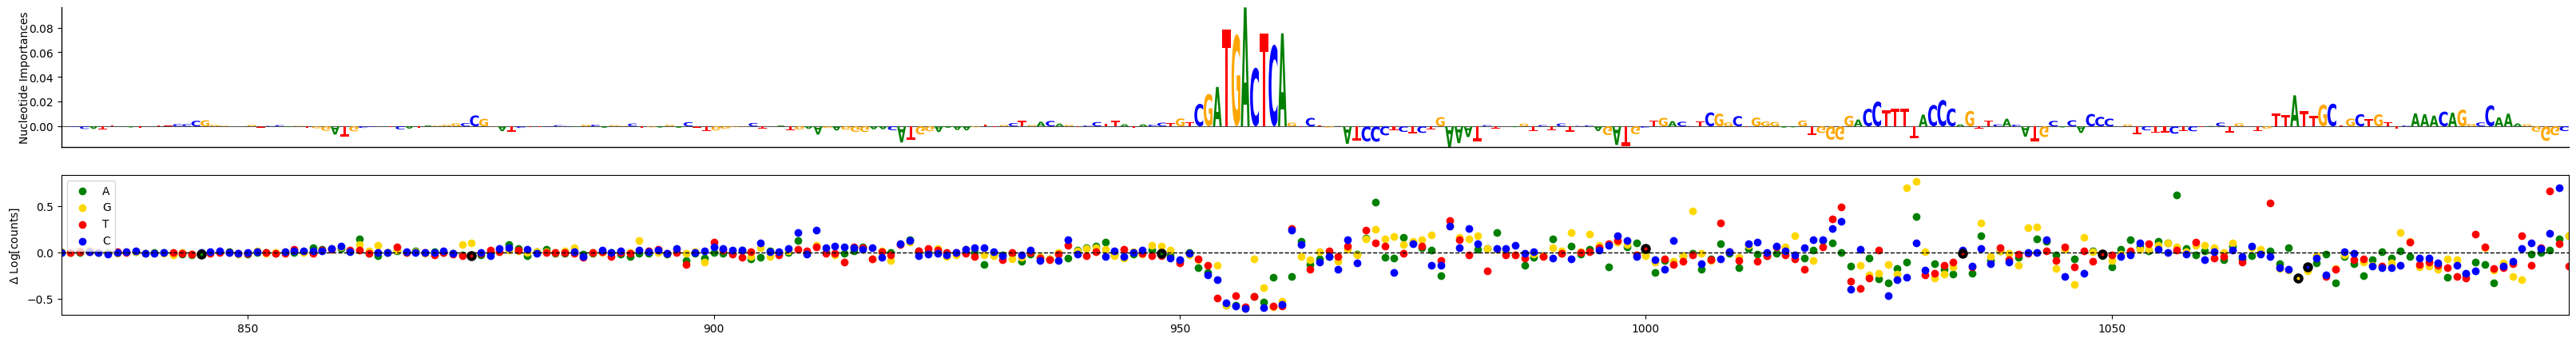

In [89]:
plot_region_ISM(seq_df_plot, ISM_df_plot,highlight_SNP=highlight_SNP,save_path="region_plots/enterocytes_IGFBP2_regions_0_trimmed_5_withISM_"+model_head+".pdf")

In [79]:
ISM_df

,pos,ref,alt,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
0,0,A,C,5.07792,0.0,0.0,NaN,5.210246,0.000000e+00,0.000000,...,0.0,0.0,5.066358,0.0,0.0,0.0,0.000000e+00,5.053468,0.000000,0.000000
1,0,A,G,5.07792,0.0,0.0,0.0,5.210246,0.000000e+00,0.000000,...,0.0,0.0,5.066358,0.0,0.0,NaN,0.000000e+00,5.053468,0.000000,0.000000
2,0,A,T,5.07792,0.0,0.0,NaN,5.210246,0.000000e+00,0.000000,...,0.0,0.0,5.066358,0.0,0.0,0.0,0.000000e+00,5.053468,0.000000,0.000000
3,1,C,A,5.07792,0.0,0.0,NaN,5.210246,0.000000e+00,0.000000,...,0.0,0.0,5.066358,0.0,0.0,0.0,0.000000e+00,5.053468,0.000000,0.000000
4,1,C,G,5.07792,0.0,0.0,NaN,5.210246,0.000000e+00,0.000000,...,0.0,NaN,5.066358,0.0,0.0,0.0,0.000000e+00,5.053468,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337,2112,G,C,5.07792,0.0,0.0,0.0,5.210246,0.000000e+00,0.000000,...,0.0,NaN,5.066358,0.0,0.0,0.0,-9.536743e-08,5.053467,-0.000004,0.000000
6338,2112,G,T,5.07792,0.0,0.0,0.0,5.210246,0.000000e+00,0.000000,...,0.0,NaN,5.066358,0.0,0.0,0.0,-9.536743e-08,5.053467,-0.000003,-0.000002
6339,2113,T,A,5.07792,0.0,0.0,0.0,5.210246,0.000000e+00,0.000000,...,0.0,0.0,5.066358,0.0,0.0,0.0,0.000000e+00,5.053468,0.000000,0.000000
6340,2113,T,C,5.07792,0.0,0.0,0.0,5.210246,-4.768372e-07,-0.000016,...,0.0,0.0,5.066358,0.0,0.0,0.0,-9.536743e-08,5.053468,-0.000003,0.000000


In [ ]:
#TGACTCA: FOS
#TTATTGC: HOXC9? (repressive mostly, but here activator)


In [29]:
min_pos

617

In [30]:
region_name

'IGFBP2_regions'

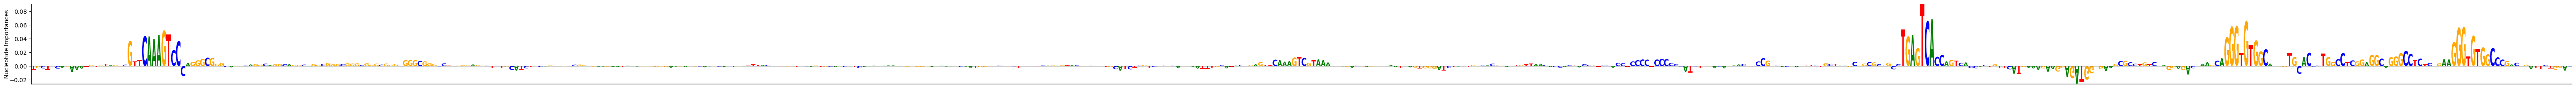

In [31]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df_trimmed,figsize=(100/2000*len(seq_df_trimmed.index)*3, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5_"+model_head+".png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5_"+model_head+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [32]:
max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>7]
min_pos = np.array(max_contrib_Z_thresh.index).min()
max_pos = np.array(max_contrib_Z_thresh.index).max()

min_pos = np.max([min_pos - 20,1])
max_pos = np.min([max_pos+20,2000])
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

ISM_df_trimmed = ISM_df.loc[ISM_df['pos']<=max_pos]
ISM_df_trimmed = ISM_df_trimmed.loc[ISM_df_trimmed['pos']>=min_pos]


517


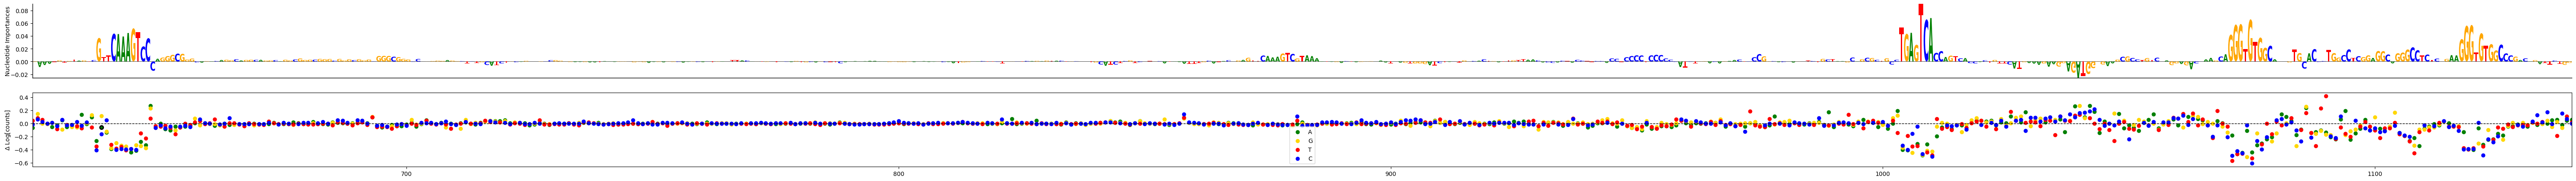

In [33]:
plot_region_ISM(seq_df_trimmed, ISM_df_trimmed,highlight_SNP=highlight_SNP,save_path="region_plots/enterocytes_"+region_name+"_regions_0_trimmed_7_withISM_"+model_head+".pdf")